<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary
The cells counter algorithm is based on watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Install libraries. Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # in the begining of lines of the code.

In [ ]:
!pip install czifile
!pip install tifffile
!pip install imagecodecs

Connect to Google disk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries.

In [ ]:
import cv2
import numpy as np
#from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border
import czifile
import imagecodecs
#import tifffile

Check the settings.

In [ ]:
#Image under study
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi'
pixels2microns = 0.396 #scale factor (check the image properties in Zen or Apeer)

#Visualisation
img_size = [0,0,512,512] # empty [] or rectangle coordinates, e.g. [0,0,512,512]
fig_size = (30,30) # figures size
img_map = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = (5,5)
ps = 5 # patch_size
pd = 3 # patch_distance
hc = 115 # coefficient

numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
markers_bias = 300

Download "czi" image and create slices of the image.

In [ ]:
img = czifile.imread(img_path + img_title)

if img_size == []:
  img_size = [0,0,img.shape[5],img.shape[6]]
img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel that is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel that is H3342-T2 (highlights all the cells)
channels = [img0,img1] # channels of the image
channelsF = channels
n = [i for i in range(len(slices))] # auxiliary variable 

print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
print('2 channels shape: ',img_slice.shape)
print('0 channel shape: ',img0.shape)
print('1 channel shape: ',img1.shape)

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
2 channels shape:  (2, 512, 512)
0 channel shape:  (512, 512)
1 channel shape:  (512, 512)


Filter image channels

In [ ]:
for i in n:
  # denoise_nl_means performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=pd, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  channelsF[i] = np.uint16(channelsF[i])
  # Calculate a multidimensional median filter
  channelsF[i]= ndimage.median_filter(channelsF[i], size=kernel4filt[0])

  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
   

0 channel shape:  (512, 512) uint16 <class 'numpy.ndarray'>
1 channel shape:  (512, 512) uint16 <class 'numpy.ndarray'>


Visualize channels before and after filtering.

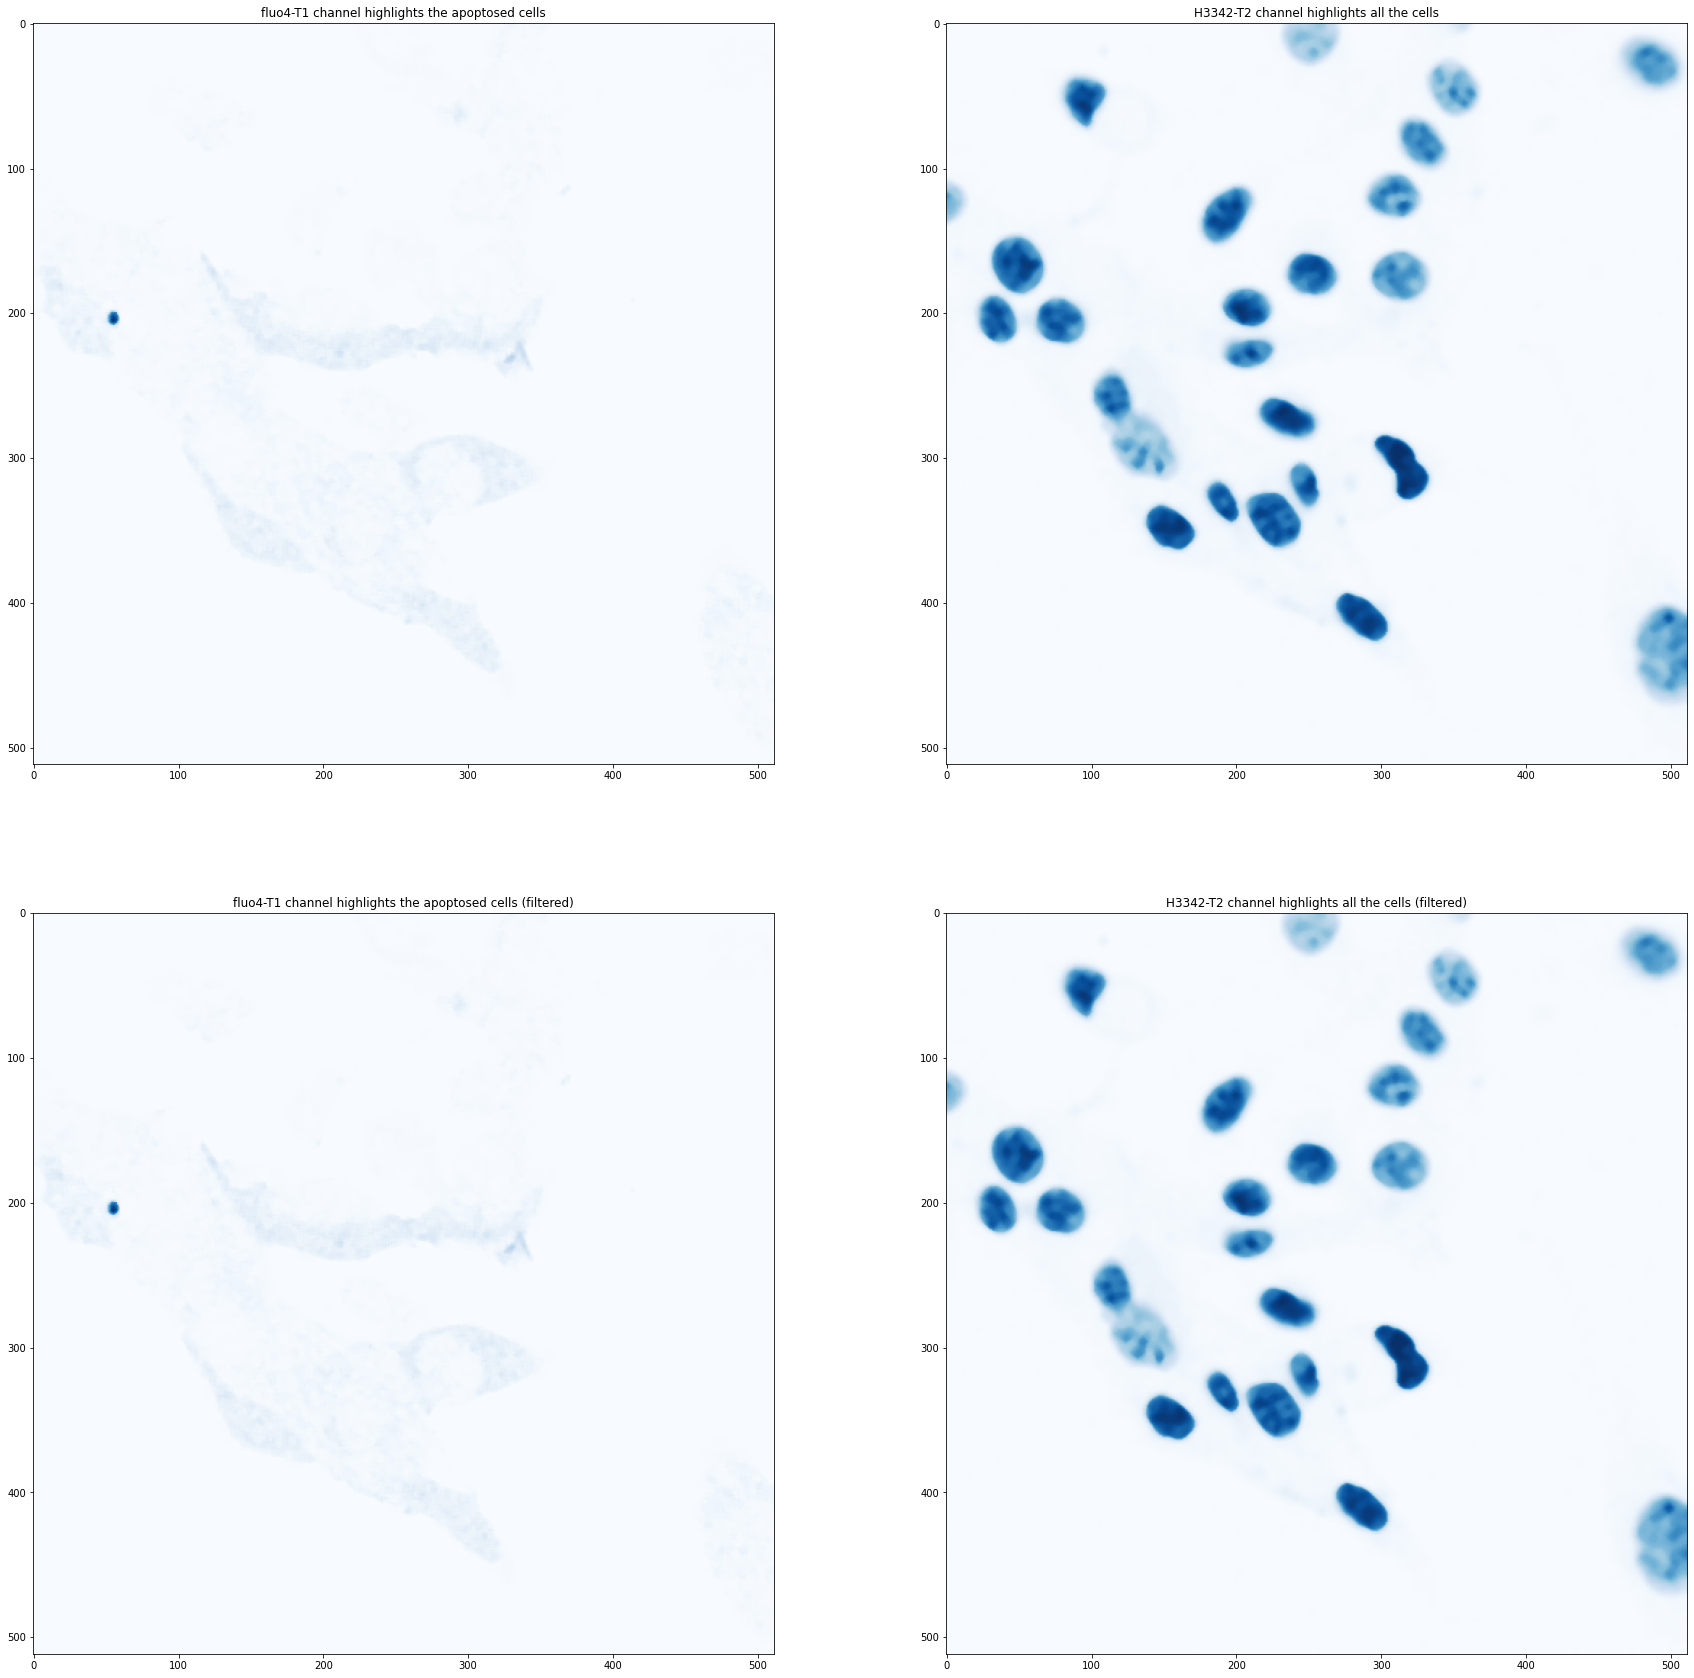

In [ ]:
titles = ['fluo4-T1 channel highlights the apoptosed cells',
          'H3342-T2 channel highlights all the cells']

plt.figure(figsize=(fig_size[0],fig_size[1]))

for i in range(len(slices)):
  plt.subplot(2,2,i+1)
  plt.imshow(channels[i],cmap=img_map)
  plt.title(titles[i])

  plt.subplot(2,2,i+3)
  plt.imshow(channelsF[i],cmap=img_map)
  plt.title(titles[i]+' (filtered)')

In [ ]:
plt.figure(figsize=(img_size[0],img_size[1]/2))
plt.subplot(1,2,1)
plt.title('H3342-T2 channel highlights all the cells')
plt.imshow(img1)

plt.subplot(1,2,2)
plt.title('fluo4-T1 channel highlights the apoptosed cells')
plt.imshow(img0)

Create tepmorary files.

In [ ]:
img_path_temp0 = img_path + img_title[0:-4] + '_ch0.tiff' # path 0
img_path_temp1 = img_path + img_title[0:-4] + '_ch1.tiff' # path 1
cv2.imwrite(img_path_temp0, img0) # save img0 in tiff file (temporary file)
cv2.imwrite(img_path_temp1, img1) # save img1 in tiff file (temporary file)
img_path_temp1

Read image using OpenCV.

In [ ]:
img1gray = cv2.imread(img_path_temp1,cv2.IMREAD_GRAYSCALE)
#cv2_imshow(img1temp)
print(type(img1gray),img1gray.shape,img1gray.dtype)

Threshold image to binary using OTSU. ALl thresholded pixels are set to 255. Then remove noise (opening) and remove edge touching with clear_border function.

In [ ]:
ret1, thresh1 = cv2.threshold(img1gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
opening1 = cv2.morphologyEx(thresh1,cv2.MORPH_OPEN,kernel, iterations = numberOfIter)
opening1 = clear_border(opening1)
#cv2_imshow(opening1)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=1)
#cv2.imshow('Opening Image', thresh)

Identify background and foreground area (OpenCV - Distance Transformation)

In [ ]:
sure_bg1 = cv2.dilate(opening1,kernel,iterations=numberOfIter)
#cv2_imshow(sure_bg1) # sure background

In [ ]:
dist_transform1 = cv2.distanceTransform(opening1,cv2.DIST_L2,5)
ret12, sure_fg1 = cv2.threshold(dist_transform1, dist_transf_ratio*dist_transform1.max(), 255,0)
sure_fg1 = np.uint8(sure_fg1)
cv2_imshow(sure_fg1) # sure foreground

In [ ]:
unknown1 = cv2.subtract(sure_bg1, sure_fg1)
ret13, markers1 = cv2.connectedComponents(sure_fg1)
markers1 = markers1 + markers_bias

markers1[unknown1==255] = 0
#markers1 = np.uint8(markers1)
#cv2_imshow(unknown)
plt.figure(figsize=img_size)
plt.imshow(markers1, cmap='jet')
print(type(sure_fg1),sure_fg1.shape,sure_fg1.dtype)
print(type(markers1),markers1.shape,markers1.dtype)

In [ ]:
#markers1 = np.uint8(markers1)
#img1 = np.uint8(img1)
#print(type(markers1),markers1.shape,markers1.dtype)
#print(type(img1),img1.shape,img1.dtype)
markers1 = cv2.watershed(cv2.imread(img_path_temp1),markers1) #The boundary region will be marked -1


In [ ]:
imgC = cv2.imread(img_path_temp1)
imgC[markers1 == -1] = [0,0,255]
imgC2 = color.label2rgb(markers1, bg_label=0)
#cv2_imshow(markers1)
cv2_imshow(imgC)
#cv2_imshow(imgC2,)
plt.figure(figsize=img_size)
plt.imshow(imgC2, cmap='jet')

Calculate metrics.

In [ ]:
regions = measure.regionprops(markers1, intensity_image=img1, )
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']
output_file = open('image_measurements.csv', 'w')
output_file.write('Grain #' + "," + "," + ",".join(propList) + '\n') #join strings in array by commas, 

#First cell to print grain number
#Second cell blank as we will not print Label column

grain_number = 1
for region_props in regions:
    output_file.write(str(grain_number) + ',')
    #output cluster properties to the excel file
#    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels2microns**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels2microns
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
    grain_number += 1
output_file.close()   #Closes the file, otherwise it would be read only. 
print('Number of cells is equal to',grain_number)

In [ ]:
print(propList)
print(region_props)
#print(markers1)
print(len(regions))

In [ ]:
print(markers1.shape)
markers1[100,100]

In [ ]:
#img4 = cv2.imread('/content/drive/MyDrive/Cells_count/B16_1122_2_2.czi')
#img_RGB = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.imshow('Color picture from opencv',img4)
#edges = cv2.Canny(img3, 100, 200)
#print(img3.shape)